In [1]:
import pandas as pd
import numpy as np
import eli5
from scipy.stats import lognorm, loguniform, randint
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

## Introduction

This is a multi-class classification problem. The task is to predict whether the outcome of the case will be no relief, relief or conditional order. The dataset is of small size. The number of features is rather large. There is no missing values. Most features are numerically encoded after cleaning. "What was the location of the landlord tenant board?" is the only categorical features besides "case number" and "Who was the member adjudicating the decision?", which will be dropped later.

In [3]:
# Load Data
df = pd.read_csv('../data/cleaned_data_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 47 columns):
 #   Column                                                                                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                         --------------  -----  
 0   case number                                                                                                                                                                                                                    696 non-null    object 
 1   Who was the member adjudicating the decision?                                                                                         

## Data Splitting

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns = ["What was the outcome of the case?"]), train_df["What was the outcome of the case?"]
X_test, y_test = test_df.drop(columns = ["What was the outcome of the case?"]), test_df["What was the outcome of the case?"]
print("train set:", train_df.shape)
print("test set:", test_df.shape)
train_df.head()

train set: (556, 47)
test set: (140, 47)


,case number,Who was the member adjudicating the decision?,What was the location of the landlord tenant board?,Did the decision state the landlord was represented?,Did the decision state the landlord attended the hearing?,Did the decision state the tenant was represented?,Did the decision state the tenant attended the hearing?,Did the decision state the landlord was a not-for-profit landlord (e.g. Toronto Community Housing)?,Did the decision state the tenant was collecting a subsidy?,What was the outcome of the case?,...,L9 present?,N5 present?,N6 present?,N7 present?,N8 present?,T1 present?,T2 present?,T3 present?,T5 present?,T6 present?
195,TSL-90833-17,roger rodrigues,Toronto,1,0,0,0,0,0,No relief,...,0,0,0,0,0,0,0,0,0,0
553,TNL-07861-18,nancy morris,Toronto,0,1,0,1,0,0,No relief,...,0,0,0,0,0,0,0,0,0,0
598,TSL-96267-18,david mungovan,Toronto,1,0,0,1,0,0,Relief,...,0,0,0,0,0,0,0,0,0,0
645,TEL-81094-17,shelby whittick,Whitby,0,1,0,1,0,0,No relief,...,0,0,0,0,0,0,0,0,0,0
634,TEL-80073-17,jim mcmaster,Toronto,1,1,0,1,0,0,Relief,...,0,0,0,0,0,0,1,0,0,0


## EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 195 to 510
Data columns (total 47 columns):
 #   Column                                                                                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                         --------------  -----  
 0   case number                                                                                                                                                                                                                    556 non-null    object 
 1   Who was the member adjudicating the decision?                                                                                       

In [6]:
y_train.value_counts(normalize=True)

No relief            0.633094
Relief               0.359712
Conditional Order    0.007194
Name: What was the outcome of the case?, dtype: float64

In [7]:
# from sklearn.metrics import f1_score, make_scorer, recall_score

# custom_scorer = make_scorer(f1_score, average="macro")
# scoring_metric = custom_scorer

In [8]:
#!pip install altair_ally
#!pip install altair_data_server

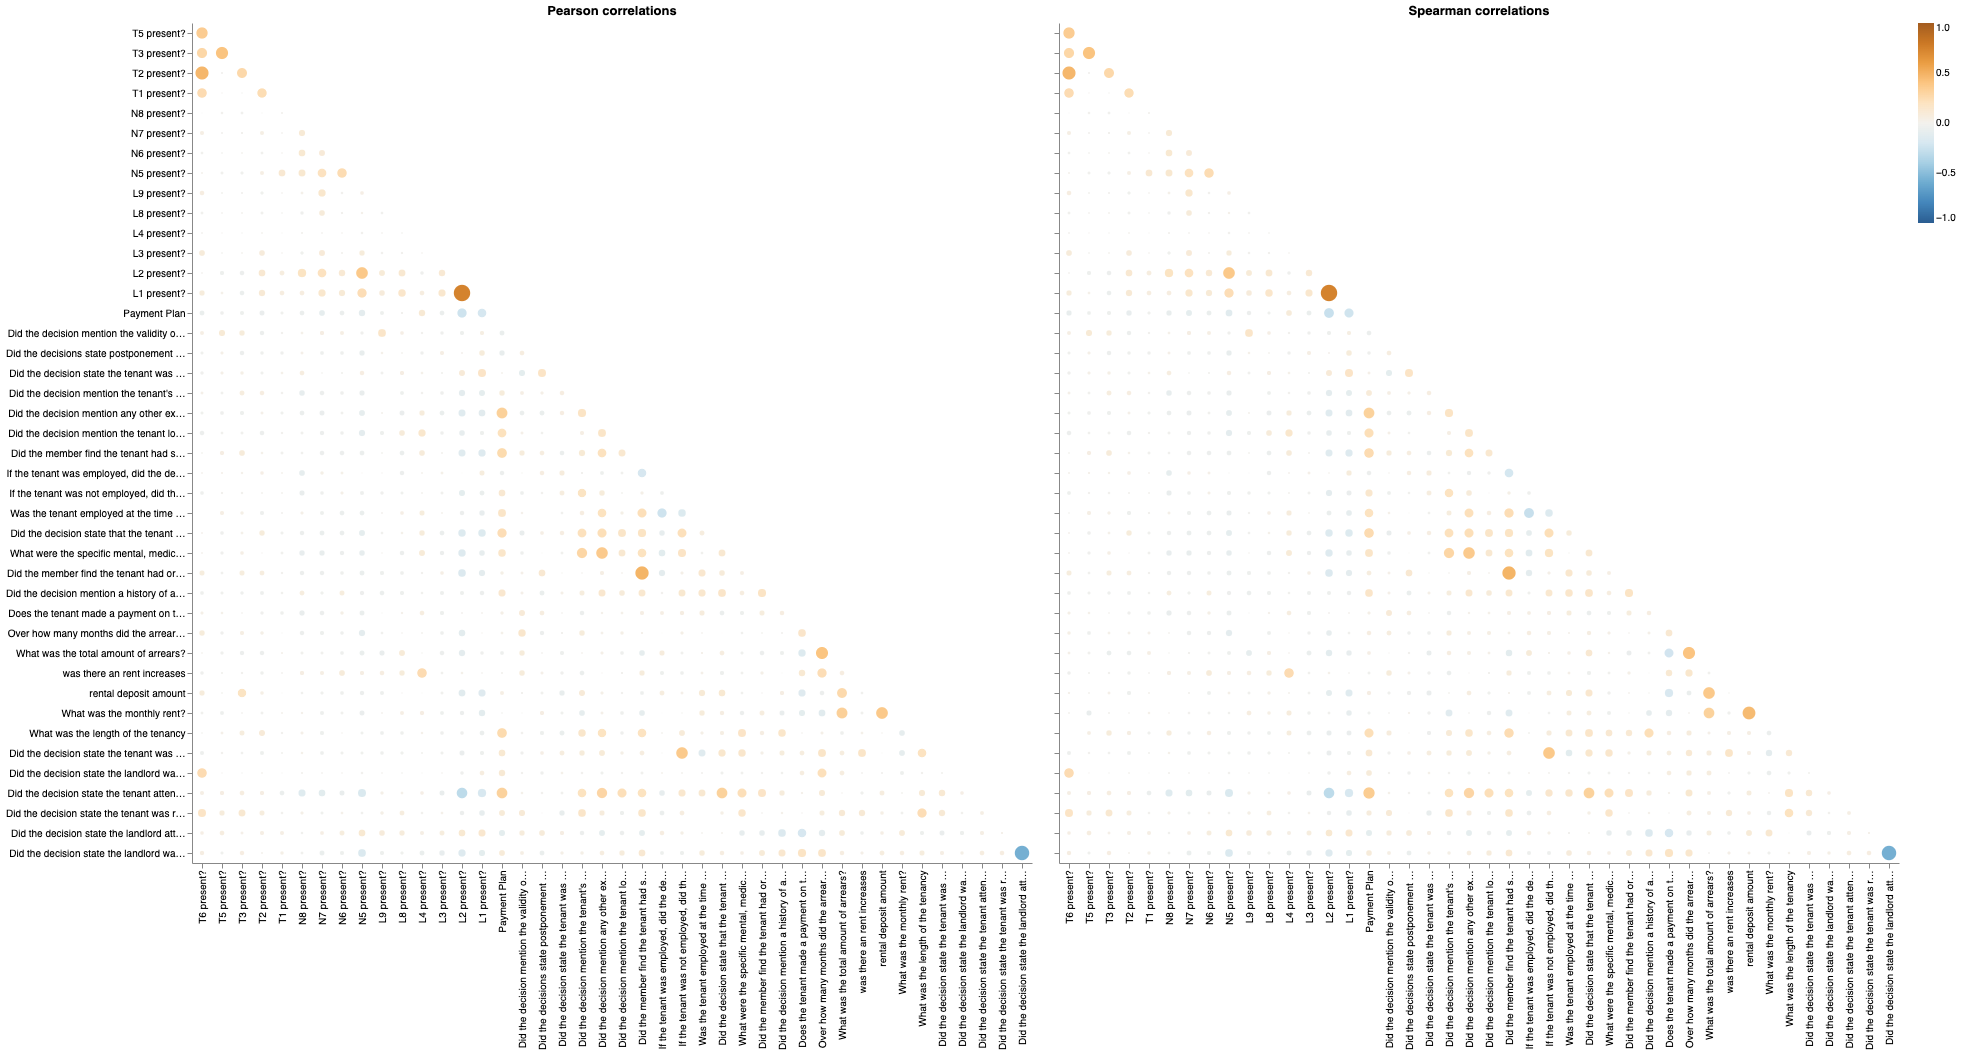

In [9]:
# correlation graphs
import altair_ally as aly
from altair_data_server import data_server

aly.alt.data_transformers.enable('data_server')
aly.alt.renderers.enable('mimetype')

aly.corr(train_df)

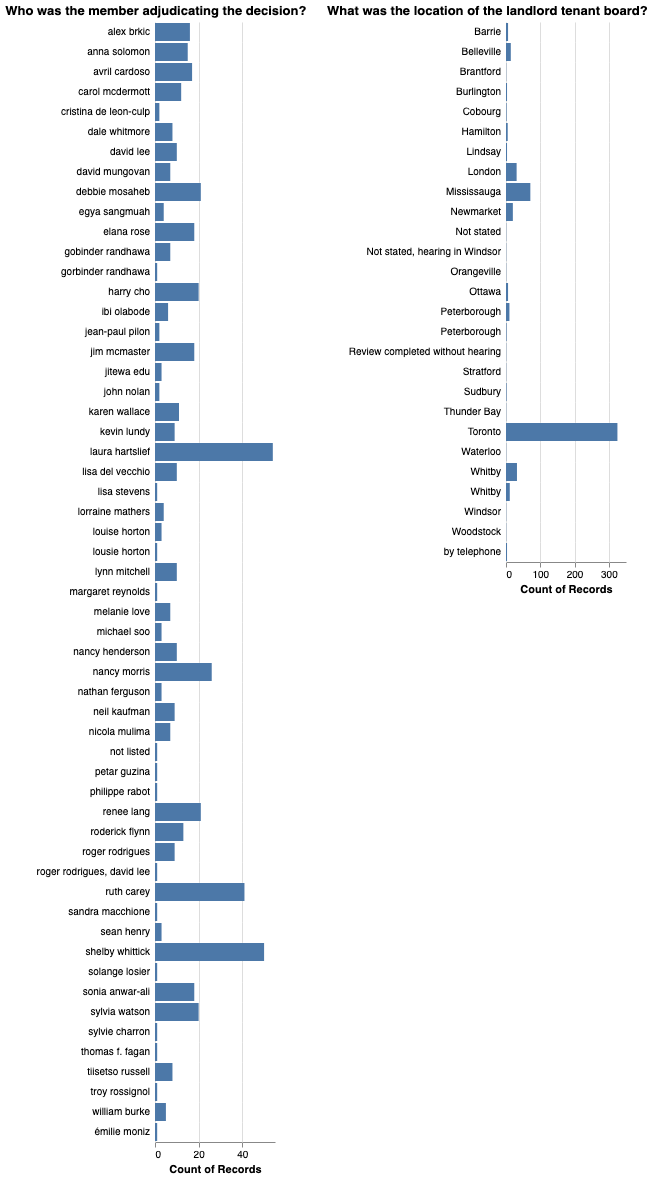

In [10]:
# count of categorical features
categorical_features = ['Who was the member adjudicating the decision?',
                        'What was the location of the landlord tenant board?']
aly.dist(train_df[categorical_features].astype('object'), dtype='object').resolve_scale(y='independent')

## Preprocessing and Transformations

In [11]:
categorical_features = ['What was the location of the landlord tenant board?']

numeric_features = [
    'What was the length of the tenancy',
    'What was the monthly rent?',
    'rental deposit amount',
    'What was the total amount of arrears?',
    'Over how many months did the arrears accumulate?'
]

ordinal_features = [
    'Was the tenant employed at the time of the hearing?',
    'If the tenant was not employed, did the decision state the tenant was receiving any form of government assistance (e.g. OW, childcare benefits, ODSP, OSAP)?',
    'If the tenant was employed, did the decision state any doubts about the stability of employment e.g. lack of guaranteed hours, contract work, etc.?',
    'Payment Plan'
]

drop_features = [
    'case number',
    'Who was the member adjudicating the decision?'
]

ordering_ordinal = [
    [-1,0,1],
    [-1,0,1],
    [-1,0,1],
    [0, 0.5, 1]
]

passthrough_feats = list(
    set(X_train.columns)
    - set(categorical_features)
    - set(numeric_features)
    - set(ordinal_features)
    - set(drop_features)
)

In [12]:
preprocessor = make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"),categorical_features),
        ("passthrough", passthrough_feats),
        (StandardScaler(),numeric_features),
        (OrdinalEncoder(categories = ordering_ordinal),ordinal_features),
        ("drop",drop_features))
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['What was the location of the landlord '
                                  'tenant board?']),
                                ('passthrough', 'passthrough',
                                 ['Did the decision mention the tenant lost '
                                  'their job leading up to or during the '
                                  'period of the hearing?',
                                  "Did the decision mention the tenant's "
                                  'difficulty finding alternative housing for '
                                  'any reason e.g.phy...
                                  'If the tenant was not employed, did the '
                                  'decision state the tenant was receiving any '
                                  'form of government assistance (e.g. OW, '
                                  'childcare benefits, ODSP, OSAP)?',
                                  'If the tenant was employed, did the '
                                  'decision state any doubts about the '
                                  'stability of employment e.g. lack of '
                                  'guaranteed hours, contract work, etc.?',
                                  'Payment Plan']),
                                ('drop', 'drop',
                                 ['case number',
                                  'Who was the member adjudicating the '
                                  'decision?'])])

## Baseline Model

In [13]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}
scoring_metric = ["accuracy"]

In [14]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, scoring = scoring_metric, return_train_score=True
)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)


## Linear Models

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)

results["logistic regression"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)


In [16]:
# Logistic regression hyperparameter optimization
param_grid = { 
    "logisticregression__C": loguniform(1e-3, 1e3),
    "logisticregression__class_weight": ["balanced", None]
}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    scoring=scoring_metric,
    refit='accuracy',
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

tuning_results = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_accuracy",
        "param_logisticregression__C",
        "param_logisticregression__class_weight",
        "mean_fit_time",
        "rank_test_accuracy"
    ]
].set_index("rank_test_accuracy").sort_index()[:10]

tuning_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameter values:  {'logisticregression__C': 5.806334557802442, 'logisticregression__class_weight': None}
Best score: 0.761


,mean_test_accuracy,param_logisticregression__C,param_logisticregression__class_weight,mean_fit_time
rank_test_accuracy,,,,
1,0.760859,5.806335,None,0.096345
1,0.760859,5.800879,None,0.085968
3,0.759089,10.372482,None,0.120228
4,0.759073,12.240653,None,0.125821
5,0.759041,0.3615,None,0.046799
5,0.759041,0.42799,None,0.050714
5,0.759041,0.369131,None,0.044927
8,0.757272,26.789983,None,0.159162
8,0.757272,21.610275,None,0.154055


In [17]:
# best lr model
best_lr = random_search.best_estimator_
results["logistic regression (tuned)"] = mean_std_cross_val_scores(
    best_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)


- Logistic regression scores are better than the dummy classifier scores. 
- Optimizing the regularization hyperparameter of logistic regression improved the validation scores slightly from 0.748 to 0.761.

In [18]:
# eli5 feature importance weights for lr
categorical_feature_names = (
    random_search.best_estimator_
    .named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

feature_names = (
    categorical_feature_names + passthrough_feats + numeric_features + ordinal_features
)

best_lr.fit(X_train, y_train)

eli5.explain_weights(
    best_lr.named_steps["logisticregression"], feature_names=feature_names
)

Explanation(estimator='LogisticRegression(C=5.806334557802442, max_iter=2000, random_state=123)', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Conditional Order', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='What was the location of the landlord tenant board?_Ottawa', weight=2.563415066798148, std=None, value=None), FeatureWeight(feature='Did the member find the tenant had sufficient income to pay rent?', weight=1.5069673746088363, std=None, value=None), FeatureWeight(feature='N8 present?', weight=1.4586851235414326, std=None, value=None), FeatureWeight(feature='Did the decision state the landlord was represented?', weight=1.1835516727302904, std=None, value=None), FeatureWeight(feature='Did the decision state that the tenant had children living with them?', weight=0.6600036232902514, std=None, value=None), FeatureWeight(feature='What was the monthly rent?', weight=0.6016476010987346, std=None, value=None), FeatureWeight(feature='Did the decision state the tenant was given prior notice for the eviction?', weight=0.566672880945222, std=None, value=None), FeatureWeight(feature='Was the tenant employed at the time of the hearing?', weight=0.5200030004232904, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-5.830856900467829, std=None, value=None), FeatureWeight(feature='L1 present?', weight=-1.4977652225645903, std=None, value=None), FeatureWeight(feature='Does the tenant made a payment on the arrears after the eviction notice', weight=-1.4446371397525348, std=None, value=None), FeatureWeight(feature='What was the total amount of arrears?', weight=-1.229092161966417, std=None, value=None), FeatureWeight(feature='rental deposit amount', weight=-1.1059010813080188, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Mississauga', weight=-0.7813896422819026, std=None, value=None), FeatureWeight(feature='Did the decision mention any other extenuating circumstances experienced by the tenant leading up to or during the period of the claim (e.g. hospitalization, death in the family, etc.)?', weight=-0.7455272497309101, std=None, value=None), FeatureWeight(feature='What was the length of the tenancy', weight=-0.7379643473458476, std=None, value=None), FeatureWeight(feature='Did the member find the tenant had or seemed to have the ability to pay rent, but chose not do so?', weight=-0.6614706490272122, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Newmarket', weight=-0.5288927933956007, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Toronto', weight=-0.4901590637385477, std=None, value=None), FeatureWeight(feature='What were the specific mental, medical, or physical conditions of the tenant, if any?', weight=-0.4710796239601453, std=None, value=None)], pos_remaining=8, neg_remaining=43), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='No relief', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=4.610618672367519, std=None, value=None), FeatureWeight(feature='T3 present?', weight=1.8623924303247958, std=None, value=None), FeatureWeight(feature='L1 present?', weight=1.1952273235753488, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Sudbury', weight=1.1595542596572614, std=None, value=None), Feat

### SVM (Linear SVC)

In [19]:
from sklearn import svm

pipe_svm = make_pipeline(
    preprocessor, svm.LinearSVC(max_iter=30000, random_state=123)
)

results["SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)


In [20]:
# Linear SVC hyperparameter optimization

param_grid_svm = { 
    "linearsvc__C": loguniform(1e-4, 1e1),
    "linearsvc__multi_class": ["ovr","crammer_singer"],
    "linearsvc__class_weight": ["balanced", None]
}

random_search_svm = RandomizedSearchCV(
    pipe_svm,
    param_grid_svm,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    scoring=scoring_metric,
    refit='accuracy',
    random_state=123,
    return_train_score=True,
)

random_search_svm.fit(X_train, y_train)

print("Best hyperparameter values: ", random_search_svm.best_params_)
print("Best score: %0.3f" % (random_search_svm.best_score_))

tuning_results_svm = pd.DataFrame(random_search_svm.cv_results_)[
    [
        "mean_test_accuracy",
        "param_linearsvc__C",
        "param_linearsvc__multi_class",
        "param_linearsvc__class_weight",
        "mean_fit_time",
        "rank_test_accuracy"
    ]
].set_index("rank_test_accuracy").sort_index()[:10]

tuning_results_svm

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/AliceYuuu/opt/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/AliceYuuu/opt/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameter values:  {'linearsvc__C': 1.6282166373084725, 'linearsvc__class_weight': None, 'linearsvc__multi_class': 'ovr'}
Best score: 0.764


,mean_test_accuracy,param_linearsvc__C,param_linearsvc__multi_class,param_linearsvc__class_weight,mean_fit_time
rank_test_accuracy,,,,,
1,0.764447,1.628217,ovr,None,0.184871
2,0.759025,0.658285,ovr,None,0.079557
3,0.757272,0.060803,ovr,balanced,0.023829
4,0.757255,4.223402,ovr,None,0.326161
5,0.757223,0.092445,ovr,None,0.023658
6,0.753604,0.059145,ovr,None,0.021126
7,0.748246,0.22211,crammer_singer,None,0.051013
8,0.748230,0.015591,ovr,None,0.020218
9,0.748214,0.13685,crammer_singer,None,0.034950


In [21]:
# Best svm model
best_svm = random_search_svm.best_estimator_
results["SVM (tuned)"] = mean_std_cross_val_scores(
    best_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)


- Linear SVC scores are a bit better than the logistic regression classifier scores. 
- Optimizing the regularization hyperparameter of linear SVM did not really improve the validation scores (0.764).

In [22]:
# eli5 feature importance weights for lr
categorical_feature_names = (
    random_search_svm.best_estimator_
    .named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

feature_names = (
    categorical_feature_names + passthrough_feats + numeric_features + ordinal_features
)

best_svm.fit(X_train, y_train)

eli5.explain_weights(
    best_svm.named_steps["linearsvc"], feature_names=feature_names
)

Explanation(estimator='LinearSVC(C=1.6282166373084725, max_iter=30000, random_state=123)', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Conditional Order', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='What was the location of the landlord tenant board?_Ottawa', weight=1.0150430594058766, std=None, value=None), FeatureWeight(feature='Did the member find the tenant had sufficient income to pay rent?', weight=0.871316930345789, std=None, value=None), FeatureWeight(feature='N8 present?', weight=0.7805074526078715, std=None, value=None), FeatureWeight(feature='Did the decision state the landlord was represented?', weight=0.5034492584339829, std=None, value=None), FeatureWeight(feature='Did the decision mention the tenant lost their job leading up to or during the period of the hearing?', weight=0.3674315291927374, std=None, value=None), FeatureWeight(feature='Did the decision state the landlord attended the hearing?', weight=0.3447102427082984, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.2258286701474967, std=None, value=None), FeatureWeight(feature='L1 present?', weight=-0.9787706719185795, std=None, value=None), FeatureWeight(feature='Does the tenant made a payment on the arrears after the eviction notice', weight=-0.8430036662824842, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Newmarket', weight=-0.7681079935574682, std=None, value=None), FeatureWeight(feature='What were the specific mental, medical, or physical conditions of the tenant, if any?', weight=-0.6479295988804098, std=None, value=None), FeatureWeight(feature='rental deposit amount', weight=-0.6133041613062254, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Mississauga', weight=-0.5227291130943735, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Toronto', weight=-0.4834579571111773, std=None, value=None), FeatureWeight(feature='What was the total amount of arrears?', weight=-0.4769622860019851, std=None, value=None), FeatureWeight(feature='If the tenant was employed, did the decision state any doubts about the stability of employment e.g. lack of guaranteed hours, contract work, etc.?', weight=-0.409581540428691, std=None, value=None), FeatureWeight(feature='If the tenant was not employed, did the decision state the tenant was receiving any form of government assistance (e.g. OW, childcare benefits, ODSP, OSAP)?', weight=-0.3011988431058326, std=None, value=None), FeatureWeight(feature='Did the member find the tenant had or seemed to have the ability to pay rent, but chose not do so?', weight=-0.290250979132647, std=None, value=None), FeatureWeight(feature='Was the tenant employed at the time of the hearing?', weight=-0.25629034202201045, std=None, value=None), FeatureWeight(feature='was there an rent increases', weight=-0.24524858150679466, std=None, value=None)], pos_remaining=8, neg_remaining=22), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='No relief', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='T3 present?', weight=1.52507625781503, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=1.002237788745668, std=None, value=None), FeatureWeight(feature='What was the location of the landlord tenant board?_Sudbury', weight=0.9423040005138318, std=None, value=No

## Non-linear Tree-based Models

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123)
)

results["random forest"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)
random forest,0.113 (+/- 0.005),0.013 (+/- 0.001),0.788 (+/- 0.045),1.000 (+/- 0.000)


In [24]:
# Random forest hyperparameter optimization 
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
    "randomforestclassifier__class_weight": ["balanced", None]
}

random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    scoring=scoring_metric,
    refit='accuracy',
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)

print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

tuning_results_rf = pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_test_accuracy",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__class_weight",
        "mean_fit_time",
        "rank_test_accuracy"
    ]
].set_index("rank_test_accuracy").sort_index()[:10]

tuning_results_rf

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameter values:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__n_estimators': 46}
Best score: 0.802


,mean_test_accuracy,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__class_weight,mean_fit_time
rank_test_accuracy,,,,,
1,0.802317,46,16,None,0.121711
2,0.793227,77,14,None,0.189604
3,0.791538,22,19,None,0.066457
4,0.791474,93,16,None,0.221210
5,0.789688,84,16,None,0.203371
6,0.789640,32,12,balanced,0.086488
7,0.789624,67,12,None,0.180197
8,0.789607,50,8,None,0.106984
9,0.789591,22,8,None,0.059244


In [25]:
# Best random forest model
best_rf = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)
random forest,0.113 (+/- 0.005),0.013 (+/- 0.001),0.788 (+/- 0.045),1.000 (+/- 0.000)
random forest (tuned),0.058 (+/- 0.002),0.008 (+/- 0.000),0.802 (+/- 0.059),0.991 (+/- 0.002)


- Random forest classifier scores are better than the linear models scores. 
- Optimizing the regularization hyperparameter of random forest classifier improved the validation scores slightly from 0.795 to 0.800.

In [26]:
# eli5 feature importance weights for lr
categorical_feature_names = (
    random_search_rf.best_estimator_
    .named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

feature_names = (
    categorical_feature_names + passthrough_feats + numeric_features + ordinal_features
)

best_rf.fit(X_train, y_train)

eli5.explain_weights(
    best_rf.named_steps["randomforestclassifier"], top=None, feature_names=feature_names
)

Weight,Feature
0.1003 ± 0.0641,What was the total amount of arrears?
0.0888 ± 0.1038,Payment Plan
0.0857 ± 0.1196,Did the decision state the tenant attended the hearing?
0.0715 ± 0.0592,rental deposit amount
0.0625 ± 0.0486,Over how many months did the arrears accumulate?
0.0447 ± 0.0362,What was the monthly rent?
0.0438 ± 0.0665,"Did the decision mention the tenant's difficulty finding alternative housing for any reason e.g.physical limitations, reliance on social assistance, etc.?"
0.0414 ± 0.0559,What was the length of the tenancy
0.0321 ± 0.0640,"What were the specific mental, medical, or physical conditions of the tenant, if any?"
0.0301 ± 0.0504,"If the tenant was employed, did the decision state any doubts about the stability of employment e.g. lack of guaranteed hours, contract work, etc.?"


### LightGBM

In [27]:
from lightgbm.sklearn import LGBMClassifier

pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123)
)

results["LightGBM"] = mean_std_cross_val_scores(
    pipe_lgbm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)
random forest,0.113 (+/- 0.005),0.013 (+/- 0.001),0.788 (+/- 0.045),1.000 (+/- 0.000)
random forest (tuned),0.058 (+/- 0.002),0.008 (+/- 0.000),0.802 (+/- 0.059),0.991 (+/- 0.002)
LightGBM,0.088 (+/- 0.003),0.006 (+/- 0.000),0.795 (+/- 0.022),1.000 (+/- 0.000)


In [28]:
# LightGBM hyperparameter optimization 
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": np.arange(0.01, 0.3, 0.001),
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
    "lgbmclassifier__class_weight": ["balanced", None]
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    scoring=scoring_metric,
    refit='accuracy',
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

tuning_results_lgbm = pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_test_accuracy",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__max_depth",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "param_lgbmclassifier__class_weight",
        "mean_fit_time",
        "rank_test_accuracy"
    ]
].set_index("rank_test_accuracy").sort_index()[:10]

tuning_results_lgbm

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameter values:  {'lgbmclassifier__class_weight': None, 'lgbmclassifier__learning_rate': 0.1269999999999999, 'lgbmclassifier__max_depth': 18, 'lgbmclassifier__n_estimators': 34, 'lgbmclassifier__subsample': 1}
Best score: 0.813


,mean_test_accuracy,param_lgbmclassifier__n_estimators,param_lgbmclassifier__max_depth,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,param_lgbmclassifier__class_weight,mean_fit_time
rank_test_accuracy,,,,,,,
1,0.812967,34,18,0.127,1,None,0.056443
2,0.811181,89,11,0.079,0.5,None,0.120088
3,0.805743,75,5,0.126,0.75,None,0.067240
4,0.803974,39,5,0.266,0.75,None,0.044723
5,0.802188,50,18,0.129,0.5,None,0.077173
6,0.800386,54,6,0.242,0.5,None,0.061146
7,0.798616,24,10,0.118,1,None,0.044094
8,0.798584,86,3,0.07,0.5,None,0.054655
9,0.796831,68,13,0.139,0.75,None,0.096736


In [29]:
# Best LightGBM model
best_lgbm = random_search_lgbm.best_estimator_
results["LightGBM (tuned)"] = mean_std_cross_val_scores(
    best_lgbm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)
random forest,0.113 (+/- 0.005),0.013 (+/- 0.001),0.788 (+/- 0.045),1.000 (+/- 0.000)
random forest (tuned),0.058 (+/- 0.002),0.008 (+/- 0.000),0.802 (+/- 0.059),0.991 (+/- 0.002)
LightGBM,0.088 (+/- 0.003),0.006 (+/- 0.000),0.795 (+/- 0.022),1.000 (+/- 0.000)
LightGBM (tuned),0.038 (+/- 0.003),0.007 (+/- 0.001),0.813 (+/- 0.017),0.977 (+/- 0.009)


- LightGBM scores are a bit better than the random forest classifier scores in general.
- Optimizing the regularization hyperparameter of LightGBM classifier improved the validation scores slightly from 0.795 to 0.813.

In [30]:
# eli5 feature importance weights for lr
categorical_feature_names = (
    random_search_lgbm.best_estimator_
    .named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

feature_names = (
    categorical_feature_names + passthrough_feats + numeric_features + ordinal_features
)

best_lgbm.fit(X_train, y_train)

eli5.explain_weights(
    best_lgbm.named_steps["lgbmclassifier"], top=None, feature_names=feature_names
)

Weight,Feature
0.1714,Did the decision state the tenant attended the hearing?
0.1542,What was the total amount of arrears?
0.1108,Payment Plan
0.0912,rental deposit amount
0.0668,Over how many months did the arrears accumulate?
0.0646,Did the decision state the tenant was represented?
0.0613,"Did the decision mention the tenant's difficulty finding alternative housing for any reason e.g.physical limitations, reliance on social assistance, etc.?"
0.0357,What was the monthly rent?
0.0200,Did the member find the tenant had sufficient income to pay rent?
0.0169,"If the tenant was employed, did the decision state any doubts about the stability of employment e.g. lack of guaranteed hours, contract work, etc.?"


## Ensemble

### Averaging

In [31]:
# pick the two models with highest accuracy
classifiers = {
    "random forest": best_rf,
    "LightGBM": best_lgbm
}

In [32]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(list(classifiers.items()))

In [33]:
averaging_model.fit(X_train, y_train)

VotingClassifier(estimators=[('random forest',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('onehotencoder',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['What '
                                                                                 'was '
                                                                                 'the '
                                                                                 'location '
                                                                                 'of '
                                                                                 'the '
                                                                                 'landlord '
                                                                                 'tenant '
                                                                                 'board?']),
                                                                               ('passthrough',
                                                                                'passthrough',
                                                                                ['Did '
                                                                                 'the '
                                                                                 'decision '
                                                                                 'mention '
                                                                                 'the '
                                                                                 'tenant '
                                                                                 'lost '
                                                                                 'their '
                                                                                 'job '
                                                                                 'leading '
                                                                                 'up '
                                                                                 'to '
                                                                                 'or '
                                                                                 'dur...
                                                                                 'any '
                                                                                 'doubts '
                                                                                 'about '
                                                                                 'the '
                                                                                 'stability '
                                                                                 'of '
                                                                                 'employment '
                                                                                 'e.g. '
                                                                                 'lack '
                                                                                 'of '
                                                                                 'guaranteed '
                                                                                 'hours, '
                                                                                 'contract '
                                                                                 'work, '
                                                                                 'etc.?',
                                                              

In [34]:
results["Averaging"] = mean_std_cross_val_scores(
    averaging_model, X_train, y_train, scoring=scoring_metric, return_train_score=True
)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)
random forest,0.113 (+/- 0.005),0.013 (+/- 0.001),0.788 (+/- 0.045),1.000 (+/- 0.000)
random forest (tuned),0.058 (+/- 0.002),0.008 (+/- 0.000),0.802 (+/- 0.059),0.991 (+/- 0.002)
LightGBM,0.088 (+/- 0.003),0.006 (+/- 0.000),0.795 (+/- 0.022),1.000 (+/- 0.000)
LightGBM (tuned),0.038 (+/- 0.003),0.007 (+/- 0.001),0.813 (+/- 0.017),0.977 (+/- 0.009)
Averaging,0.152 (+/- 0.080),0.017 (+/- 0.001),0.817 (+/- 0.033),0.979 (+/- 0.005)


### Stacking

In [35]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(list(classifiers.items()))

In [36]:
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('random forest',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['What '
                                                                                   'was '
                                                                                   'the '
                                                                                   'location '
                                                                                   'of '
                                                                                   'the '
                                                                                   'landlord '
                                                                                   'tenant '
                                                                                   'board?']),
                                                                                 ('passthrough',
                                                                                  'passthrough',
                                                                                  ['Did '
                                                                                   'the '
                                                                                   'decision '
                                                                                   'mention '
                                                                                   'the '
                                                                                   'tenant '
                                                                                   'lost '
                                                                                   'their '
                                                                                   'job '
                                                                                   'leading '
                                                                                   'up '
                                                                                   'to '
                                                                                   'or '
                                                                                   'd...
                                                                                   'any '
                                                                                   'doubts '
                                                                                   'about '
                                                                                   'the '
                                                                                   'stability '
                                                                                   'of '
                                                                                   'employment '
                                                                                   'e.g. '
                                                                                   'lack '
                                                                                   'of '
                                                                                   'guaranteed '
                                                                                   'hours, '
                                                                                   'contract '
                                                                                   'work, '
                                                                    

In [37]:
results["Stacking"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, scoring=scoring_metric, return_train_score=True
)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy
dummy,0.002 (+/- 0.003),0.000 (+/- 0.000),0.633 (+/- 0.004),0.633 (+/- 0.001)
logistic regression,0.060 (+/- 0.016),0.006 (+/- 0.001),0.748 (+/- 0.050),0.825 (+/- 0.009)
logistic regression (tuned),0.046 (+/- 0.006),0.005 (+/- 0.000),0.761 (+/- 0.046),0.837 (+/- 0.013)
SVM,0.070 (+/- 0.014),0.005 (+/- 0.001),0.764 (+/- 0.039),0.833 (+/- 0.016)
SVM (tuned),0.115 (+/- 0.021),0.005 (+/- 0.000),0.764 (+/- 0.041),0.835 (+/- 0.013)
random forest,0.113 (+/- 0.005),0.013 (+/- 0.001),0.788 (+/- 0.045),1.000 (+/- 0.000)
random forest (tuned),0.058 (+/- 0.002),0.008 (+/- 0.000),0.802 (+/- 0.059),0.991 (+/- 0.002)
LightGBM,0.088 (+/- 0.003),0.006 (+/- 0.000),0.795 (+/- 0.022),1.000 (+/- 0.000)
LightGBM (tuned),0.038 (+/- 0.003),0.007 (+/- 0.001),0.813 (+/- 0.017),0.977 (+/- 0.009)
Averaging,0.152 (+/- 0.080),0.017 (+/- 0.001),0.817 (+/- 0.033),0.979 (+/- 0.005)


- Although the stacking model has the longest fit time, and the test score (0.800) is a bit lower than the averaging model (0.806), but the stacking model has a relatively small standard deviation, which is more stable and trustworthy.

## Test

In [38]:
test_score = stacking_model.score(X_test, y_test)
test_score

0.7642857142857142

In [39]:
stacking_model.classes_

array(['Conditional Order', 'No relief', 'Relief'], dtype=object)

In [40]:
test_norelief = (
    test_df.query("`What was the outcome of the case?`== 'No relief'")
    .sample(4, random_state=123)
    .drop(columns=["What was the outcome of the case?"])
)

In [41]:
stacking_model.predict(test_norelief)

array(['No relief', 'No relief', 'No relief', 'No relief'], dtype=object)

In [42]:
stacking_model.predict_proba(test_norelief)

array([[0.00443911, 0.89664453, 0.09891637],
       [0.00352981, 0.93140136, 0.06506884],
       [0.00827267, 0.73129755, 0.26042978],
       [0.00363543, 0.92781503, 0.06854954]])

In [43]:
test_relief = (
    test_df.query("`What was the outcome of the case?`== 'Relief'")
    .sample(4, random_state=123)
    .drop(columns=["What was the outcome of the case?"])
)

In [44]:
stacking_model.predict(test_relief)

array(['Relief', 'Relief', 'Relief', 'Relief'], dtype=object)

In [45]:
stacking_model.predict_proba(test_relief)

array([[0.01126806, 0.34492439, 0.64380755],
       [0.00860086, 0.08030864, 0.9110905 ],
       [0.0103172 , 0.14996022, 0.83972258],
       [0.0114317 , 0.41846994, 0.57009835]])

In [46]:
test_conditional = (
    test_df.query("`What was the outcome of the case?`== 'Conditional Order'")
    .sample(4, random_state=123)
    .drop(columns=["What was the outcome of the case?"])
)

In [47]:
stacking_model.predict(test_conditional)

array(['No relief', 'Relief', 'No relief', 'Relief'], dtype=object)

In [48]:
stacking_model.predict_proba(test_conditional)

array([[0.00512666, 0.88641242, 0.10846092],
       [0.00919745, 0.13309915, 0.85770341],
       [0.00357235, 0.93179242, 0.06463523],
       [0.00881362, 0.08763204, 0.90355434]])

- The four random samples from "No relief" class are all predicted correctly.
- The four random samples from "Relief" class are all predicted correctly.
- The four random samples from "Conditional Order" class are all predicted incorrectly, since there is way too little data for this class.

## Save

In [49]:
import joblib
joblib.dump(stacking_model, 'stacking_model.sav')

['stacking_model.sav']

In [50]:
loaded_model = joblib.load('stacking_model.sav')

In [51]:
test_score = loaded_model.score(X_test, y_test)
test_score

0.7642857142857142